# Figure 1

Presented at the start of the methods, this introduces the patient data used in this paper, motivating how patients respond in different ways. The final panel (not depicted here) will be a schematic illustrating the framework for training a DRL model.

In [2]:
import os
import sys
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("../utils")
from myUtils import TreatmentListToTS, ExtractTreatmentFromDf
from LotkaVolterraModel import LotkaVolterraModel

sys.path.append("../models")
from bruchovsky_patients import LoadPatientData

In [3]:
# Defaults for plotting
plt.style.use(["classic", "./paper.mplstyle"])

colors = {'Sensitive': '#4c9150', 'Resistant': '#a80303', 'CT':'#c28d32' , 'AT':'#143159' ,'DRL_Monthly':'#66419e'}

## Panel A - Example model fits to trial patients

In [4]:
def PlotDrug(dataDf, ax, color, plotDrugAsBar=True, currDrugBarPosition = 1.2, drugBarHeight = 0.2, **kwargs):
    # Generate drug data as time series from list
    drugConcentrationItem = TreatmentListToTS(treatmentList=ExtractTreatmentFromDf(dataDf),
                                                    tVec=dataDf['Time'])
    try:
        drugConcentrationVec += drugConcentrationItem
        max_dose = max(max_dose, np.max(drugConcentrationItem))
    except UnboundLocalError:
        drugConcentrationVec = drugConcentrationItem
        max_dose = np.max(drugConcentrationItem)

    # Optional moving average of drug value
    # drugConcentrationVec = np.array(pd.Series(drugConcentrationVec).rolling(10).mean())
    # drugConcentrationVec = np.nan_to_num(drugConcentrationVec)

    if not plotDrugAsBar: # Plot as bands that run down the full size of the figure.
        ax.fill_between(x=dataDf['Time'], y1=ax.get_ylim()[0], y2=drugConcentrationVec, linewidth=0.0,
                         alpha=0.25, step="post", label="Drug Concentration", color=color, **kwargs)

    else: # Plot as bars across top of plot. Cleaner, but can be harder to see alignment with tumour trajectory.
        # Rescale to make it fit within the bar at the top of the plot
        drugConcentrationVec = drugConcentrationVec * drugBarHeight + currDrugBarPosition
        ax.fill_between(x=dataDf['Time'], y1=currDrugBarPosition, y2=drugConcentrationVec, linewidth=0.0,
                         alpha=0.5, step="post", label="Drug Concentration", color=color, **kwargs)
        ax.hlines(xmin=dataDf['Time'].min(), xmax=dataDf['Time'].max(),
                  y=currDrugBarPosition, linewidth=3, color="black")
        # Line at the top of the drug bars
        ax.hlines(xmin=dataDf['Time'].min(), xmax=dataDf['Time'].max(),
                      y=currDrugBarPosition + drugBarHeight, linewidth=3, color="black")


In [5]:
def PlotData(dataDf, ax, feature='PSA', drugBarPosition=0.85,
             xlim=2e3, ylim=1.3, y2lim=1, markersize=10, color = 'Black'):
    # Plot the data
    ax.plot(dataDf.Time, dataDf[feature],
            linestyle="None", marker="+", markersize=markersize,
            color=color, markeredgewidth=2)

    PlotDrug(dataDf, ax, "k", plotDrugAsBar = True)

    # # Format the plot
    ax.set_xlim(0,xlim); ax.set_ylim(0, ylim)
    ax.set_xticks(np.linspace(0, xlim, 5))
    ax.tick_params(right = False, top = False)
    


In [6]:
def SimulateFit(fit_params, dataDf, dt=1, solver_kws={}):
    myModel = LotkaVolterraModel()
    myModel.SetParams(**fit_params)
    myModel.Simulate(treatmentScheduleList=ExtractTreatmentFromDf(dataDf),**solver_kws)
    # Interpolate to the desired time grid
    t_eval = np.arange(0, myModel.resultsDf.Time.max(), dt)
    trimmedResultsDic = {'Time': t_eval}
    for variable in ['S', 'R', 'TumourSize', 'DrugConcentration']:
        f = sc.interpolate.interp1d(myModel.resultsDf.Time, myModel.resultsDf[variable])
        trimmedResultsDic = {**trimmedResultsDic, variable: f(t_eval)}
    myModel.resultsDf = pd.DataFrame(trimmedResultsDic)
    return myModel

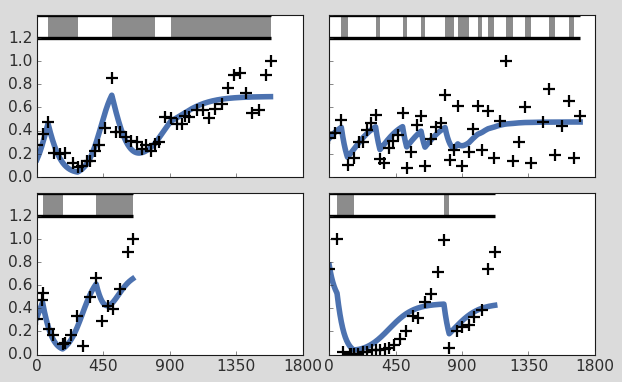

In [7]:
# Fig 0a for Zhang patients

paramList = ["cost","turnover","n0","fR"]
# patient_list = ['1007', '1009', '1014', '1020']  # For clearest fit
patient_list = ['1014', '1012', '1020', '1017']  # To match corners of param space

dataToAnalyse = pd.read_csv("data/Fig0a/fitPatientsDf_all.csv")

# Plot all fits
fig, axList = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8, 5))
for i, patientId in enumerate(patient_list):
    patient_data = pd.read_csv("data/Fig0a/patient%s.csv"%patientId)
    patient_data.rename(columns = {'Days': 'Time', 'Abi': 'DrugConcentration'}, inplace = True)
    # patient_data['Time'] = patient_data['Days']
    # patient_data['DrugConcentration'] = patient_data['Abi']
    
    patient_params = dataToAnalyse[dataToAnalyse['PatientId'] == int(patientId)].iloc[0].to_dict()
    fit_df = SimulateFit(patient_params, patient_data).resultsDf
    axList.flatten()[i].plot(fit_df['Time'], fit_df['TumourSize'], linewidth=5)
    # axList.flatten()[i].yaxis.get_major_ticks()[-1].set_visible(False);
    
    PlotData(patient_data, feature = 'relPSA_Indi', ax=axList.flatten()[i], xlim = 1.8e3, ylim=1.4)
    
axList.flatten()[0].yaxis.get_major_ticks()[-1].set_visible(False);
axList.flatten()[2].yaxis.get_major_ticks()[-1].set_visible(False);
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig("figures/fig0a_moffit_patients.png")

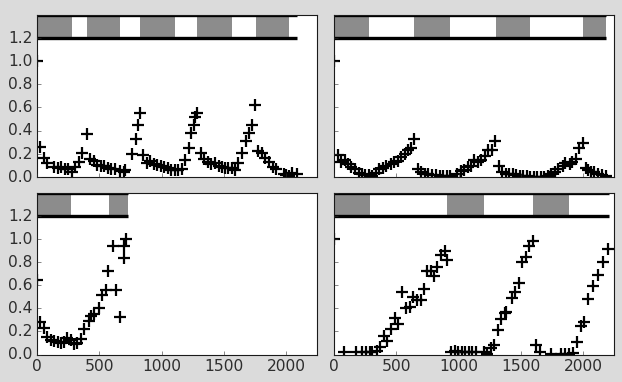

In [24]:
# Fig 0a for Bruchovsky patients

paramList = ["cost","turnover","n0","fR"]
patient_list = ['001', '028', '085', '017']  # To match corners of param space

data_dir = os.path.join(*("data/Fig0a/dataTanaka/Bruchovsky_et_al/".split('/')))

# Plot all fits
fig, axList = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8, 5))
for i, patientId in enumerate(patient_list):
    patient_data = LoadPatientData(int(patientId), data_dir)
    patient_data['PSA'] /= max(patient_data['PSA'])

    PlotData(patient_data, feature = 'PSA', ax=axList.flatten()[i], xlim = 2.25e3, ylim=1.4)
    axList.flatten()[i].set_xticks(list(range(0, 2500, 500)))

axList.flatten()[0].yaxis.get_major_ticks()[-1].set_visible(False);
axList.flatten()[2].yaxis.get_major_ticks()[-1].set_visible(False);
plt.tight_layout()
plt.subplots_adjust(wspace=0.06, hspace=0.1)
plt.savefig("figures/fig0a_bruchovsky_patients.pdf")



## Panel B - Responses of different patients to Adaptive Therapy

In [9]:
def Plot(df, legend=False, drug_label="Drug Concentration",
         ax=None, linewidth=5, **kwargs):
    if ax is None: fig, ax = plt.subplots(1, 1)
    currModelPredictionDf = pd.melt(df, id_vars=['Time'], value_vars=["TumourSize"])
    ax.plot(currModelPredictionDf['Time'], currModelPredictionDf['value'], linewidth=linewidth, **kwargs)

    # # Plot the drug concentration
    # ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    # drugConcentrationVec = TreatmentListToTS(treatmentList=ExtractTreatmentFromDf(df), tVec=df['Time'])
    # ax2.fill_between(df['Time'], 0, drugConcentrationVec, color="#8f59e0", alpha=0.2, label=drug_label)
    # ax2.set_yticklabels(""); ax2.tick_params(right=False)
    PlotDrug(df, ax, 'k', plotDrugAsBar = True, currDrugBarPosition = 0.12, drugBarHeight = 0.02)

    # Format the plot
    ax.set_title(kwargs.get('title', ''))
    # plt.tight_layout()

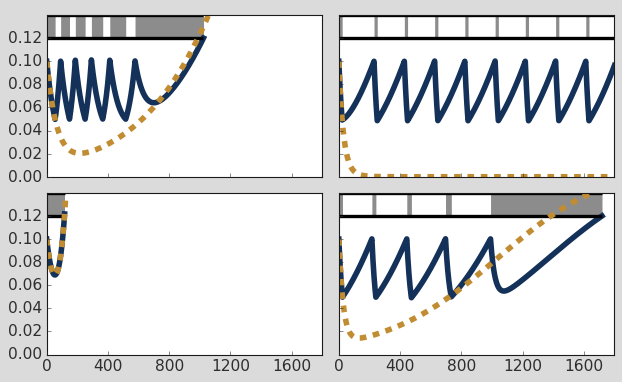

In [18]:
n0, r0 = 0.1, 0.01
rs = 0.027  # From literature
t_max = 1800

fig, axs = plt.subplots(2,2, sharex = True, sharey = True, figsize=(8, 5))

params = [[0.8, 0.1], [0.8, 0.8], [0.1, 0.1], [0.1, 0.8]]

for n in range(4):
    model = LotkaVolterraModel(method='RK45', dt = 1)
    paramDic = {"Cost": params[n][0], "Turnover": params[n][1],
                "N0": n0, "R0": r0, "S0": (n0 - r0),
                "rS": rs, "rR": rs * (1-params[n][0]),
                "dS": rs * params[n][1], "dR": rs * params[n][1],
                'K': 1.5, 'DD': 1.5}
    model.SetParams(**paramDic)
    model.Simulate_AT(atThreshold=0.5, intervalLength=1, t_end=t_max)

    ax = axs.flatten()[n]
    Plot(model.resultsDf, ax=ax, legend=False, color = colors['AT'])
    ax.set_xlim(0, t_max) #max(model.resultsDf['Time']))
    ax.set_ylim(0, 0.14)
    ax.tick_params(top=False, right=False)
    
    model.Simulate([[0, t_max, 1]])
    model.Trim(dt=1)
    ax.plot(list(model.resultsDf['Time']), list(model.resultsDf['TumourSize']), linewidth=5, linestyle='--', color=colors['CT'])

axs.flatten()[0].yaxis.get_major_ticks()[-1].set_visible(False);
axs.flatten()[2].yaxis.get_major_ticks()[-1].set_visible(False);
axs.flatten()[2].set_xticks(ax.get_xticks()[::2])
plt.tight_layout(); plt.subplots_adjust(wspace=0.06, hspace=0.1)
plt.savefig("figures/fig0b_analytic_profiles.pdf")

## Panel C - Example patient plot

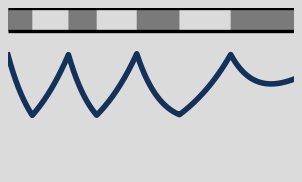

In [17]:
n0, r0 = 0.1, 0.01
cost, turnover = 0.4, 0.4
rs = 0.027  # From literature
t_max = 1800

fig, ax = plt.subplots(1, 1, figsize = (4, 2.5))


model = LotkaVolterraModel(method='RK45', dt = 1)
paramDic = {"Cost": cost, "Turnover": turnover,
            "N0": n0, "R0": r0, "S0": (n0 - r0),
            "rS": rs, "rR": rs * (1-cost),
            "dS": rs * turnover, "dR": rs * turnover,
            'K': 1.5, 'DD': 1.5}
model.SetParams(**paramDic)
model.Simulate_AT(atThreshold=0.5, intervalLength=1, t_end=t_max)

Plot(model.resultsDf, ax=ax, legend=False, color = colors['AT'], linewidth=5)
ax.set_xlim(0, model.ttp*0.8); ax.set_ylim(0, 0.14); ax.axis('off')
ax.tick_params(top=False, right=False, bottom=False, left=False)

ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.savefig("figures/fig0c_example_at.pdf")